In [7]:
import json
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u

In [2]:
# Read in both the WISE-method and direct SSDF local background measurements
with (open('Data_Repository/Project_Data/SPT-IRAGN/local_backgrounds/SPTcl-local_bkg_frac_err.json') as f,
    open('Data_Repository/Project_Data/SPT-IRAGN/local_backgrounds/SPT-SSDF_local_bkg.json') as g):
    spt_wise = json.load(f)
    spt_ssdf = json.load(g)

In [8]:
# For all clusters in the SSDF/SPTpol 100d fid the differences between the methods
surf_den_diffs = {cluster_name: ssdf_surf_den * u.deg**-2 - spt_wise[cluster_name] * u.deg**-2 for cluster_name, ssdf_surf_den in spt_ssdf.items()}

In [11]:
# Convert to arcmin-2
surf_den = u.Quantity(list(surf_den_diffs.values())).to_value(u.arcmin**-2)

[Text(0, 0.5, '$\\Sigma_{\\rm AGN, SSDF} - \\Sigma_{\\rm AGN, SDWFS}$ [arcmin$^{-2}$]')]

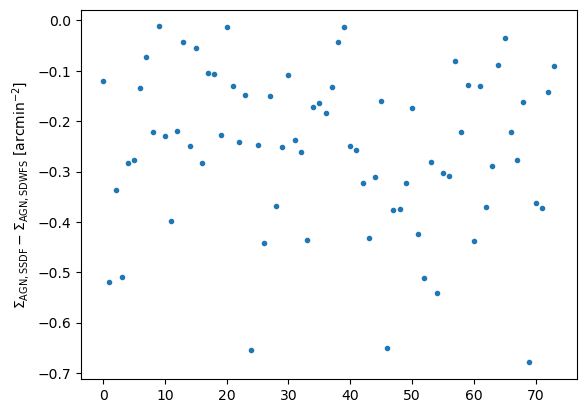

In [12]:
fig, ax = plt.subplots()
ax.scatter(np.arange(len(surf_den_diffs)), surf_den, marker='.')
ax.set(ylabel=r'$\Sigma_{\rm AGN, SSDF} - \Sigma_{\rm AGN, SDWFS}$ [arcmin$^{-2}$]')